# Multi-SOI Optimization Demo

This notebook demonstrates how to optimize the Magnetic Reference Layer (MRL) and Capping Layer structure for a **sum of SOIs** (as the paper did). The goal is to find a single structure that provides good sensitivity for a diverse range of magnetic films using the scipy library. 


In [2]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize


sys.path.append(os.path.abspath("../"))

from problems.base1 import Base1OptimizationProblem, Materials, MRL, Bounds, SOISpec, CapSpec, SubstrateSpec

##  Setup 



In [3]:
# Substrate
sub = SubstrateSpec(name="Si", rho_n=2.07, sigma=3.0)

# Candidate Caps just testing
caps = {
    "Al2O3": CapSpec(name="Al2O3", nom_thickness=50.0, rho_n=3.5, sigma=3.0),
    "Ti":    CapSpec(name="Ti",    nom_thickness=50.0, rho_n=-1.94, sigma=3.0),
    "MgO":   CapSpec(name="MgO",   nom_thickness=50.0, rho_n=5.38, sigma=3.0),
    "Au":    CapSpec(name="Au",    nom_thickness=50.0, rho_n=4.5, sigma=3.0),
    "SiO2":  CapSpec(name="SiO2",  nom_thickness=50.0, rho_n=3.4, sigma=3.0) 
}

# MRL Definition 
def magnetic_sld_func(x_coti): 
    return 1.08 * x_coti

mrl = MRL(
    rho_n_Co=1.21, 
    rho_n_Ti=-1.94, 
    m_sld_from_x=magnetic_sld_func, 
    sigma_sub_mrl=5.0, 
    sigma_mrl_cap=5.0
)

materials = Materials(substrate=sub, caps=caps, mrl=mrl)

##  Define List of SOIs


In [4]:
soi_list = [
    SOISpec(name="Film_LowDensity",  rho_n=1.0, thickness=40.0, sigma=2.0),
    SOISpec(name="Film_HighDensity", rho_n=4.0, thickness=60.0, sigma=5.0),
    SOISpec(name="Film_Thick",       rho_n=2.0, thickness=150.0, sigma=3.0),
    SOISpec(name="Film_Thin",        rho_n=3.0, thickness=20.0,  sigma=2.0)
]

print(f"Optimizing for {len(soi_list)} SOIs:")
for s in soi_list:
    print(f" - {s.name}: d={s.thickness}A, rho={s.rho_n}")

Optimizing for 4 SOIs:
 - Film_LowDensity: d=40.0A, rho=1.0
 - Film_HighDensity: d=60.0A, rho=4.0
 - Film_Thick: d=150.0A, rho=2.0
 - Film_Thin: d=20.0A, rho=3.0


##  Init Optimization Problem


In [5]:
q_grid = np.linspace(0.005, 0.3, 300)

# Bounds for variables
bounds_x = Bounds(0, 1)
bounds_d = Bounds(10, 1200) # MRL Thickness
bounds_cap = Bounds(10, 200) # Cap Thickness

problem = Base1OptimizationProblem(
    materials=materials, 
    soi_list=soi_list, 
    q_grid=q_grid, 
    bounds_x=bounds_x, 
    bounds_d=bounds_d, 
    bounds_cap=bounds_cap
)

## Run Optimization using Scipy



In [6]:
# Fixed Parameters
FIXED_X_COTI = 0.73

best_result = {
    "score": -np.inf,
    "cap": None,
    "d_mrl": 0,
    "d_cap": 0
}

results_log = []

print("Starting Optimization...")

for cap_name in caps.keys():
    print(f"\nOptimizing for Cap: {cap_name}...")
    
    
    # x vector = [d_mrl, d_cap] since thickness is capped 
    def objective_func(x):
        d_mrl_val, d_cap_val = x
        
        # The problem class sums TSF over all SOIs automatically
        score = problem.evaluate_objective(
            x_coti=FIXED_X_COTI,
            d_mrl=d_mrl_val,
            d_cap=d_cap_val,
            cap=cap_name
        )
        return -score # minimize neg

    # Initial Guess & Bounds
    x0 = [100.0, 50.0]
    bnds = [
        (bounds_d.lo, bounds_d.hi), 
        (bounds_cap.lo, bounds_cap.hi)
    ]

    # Run Scipy Minimize
    res = minimize(
        objective_func,
        x0,
        bounds=bnds,
        method='L-BFGS-B',
        tol=1e-4
    )
    
    current_score = -res.fun
    d_mrl_opt, d_cap_opt = res.x

    print(f"  > Best Score: {current_score:.4f}")
    print(f" > Params: d_mrl={d_mrl_opt:.1f}, d_cap={d_cap_opt:.1f}")
    
    results_log.append((cap_name, current_score, d_mrl_opt, d_cap_opt))
    
    if current_score > best_result["score"]:
        best_result["score"] = current_score
        best_result["cap"] = cap_name
        best_result["d_mrl"] = d_mrl_opt
        best_result["d_cap"] = d_cap_opt

print("\n" + "="*30)
print("GLOBAL OPTIMUM FOUND")
print(f"Cap: {best_result['cap']}")
print(f"MRL Thickness: {best_result['d_mrl']:.2f} A")
print(f"Cap Thickness: {best_result['d_cap']:.2f} A")
print(f"Total TSF Score: {best_result['score']:.4f}")
print("="*30)

Starting Optimization...

Optimizing for Cap: Al2O3...
  > Best Score: 0.0131
 > Params: d_mrl=100.0, d_cap=50.0

Optimizing for Cap: Ti...
  > Best Score: 0.0151
 > Params: d_mrl=100.0, d_cap=50.0

Optimizing for Cap: MgO...
  > Best Score: 0.0130
 > Params: d_mrl=100.0, d_cap=50.0

Optimizing for Cap: Au...
  > Best Score: 0.0138
 > Params: d_mrl=100.0, d_cap=50.0

Optimizing for Cap: SiO2...
  > Best Score: 0.0131
 > Params: d_mrl=100.0, d_cap=50.0

GLOBAL OPTIMUM FOUND
Cap: Ti
MRL Thickness: 100.00 A
Cap Thickness: 50.00 A
Total TSF Score: 0.0151


# Without Predefined Ratio

In [7]:
best_result = {
    "score": -np.inf,
    "cap": None,
    "x_coti": None,
    "d_mrl": None,
    "d_cap": None,
}

results_log = []

print("Starting Optimization (including x_coti)...")

# --- choose bounds for x_coti  ---
bounds_x_coti = (0.0, 1.0)

for cap_name in caps.keys():
    print(f"\nOptimizing for Cap: {cap_name}...")

    # x vector = [x_coti, d_mrl, d_cap]
    def objective_func(x):
        x_coti_val, d_mrl_val, d_cap_val = x

        score = problem.evaluate_objective(
            x_coti=float(x_coti_val),
            d_mrl=float(d_mrl_val),
            d_cap=float(d_cap_val),
            cap=cap_name
        )
        return -score  # minimize negative => maximize score

    # Initial Guess (pick something inside bounds)
    x0 = [0.73, 100.0, 50.0]

    # Bounds: [(x_coti_lo, x_coti_hi), (d_mrl_lo, d_mrl_hi), (d_cap_lo, d_cap_hi)]
    bnds = [
        bounds_x_coti,
        (bounds_d.lo, bounds_d.hi),
        (bounds_cap.lo, bounds_cap.hi),
    ]

    res = minimize(
        objective_func,
        x0,
        bounds=bnds,
        method="L-BFGS-B",
        tol=1e-4,
    )

    current_score = -float(res.fun)
    x_coti_opt, d_mrl_opt, d_cap_opt = map(float, res.x)

    print(f"  > Best Score: {current_score:.4f}")
    print(f"  > Params: x_coti={x_coti_opt:.4f}, d_mrl={d_mrl_opt:.1f}, d_cap={d_cap_opt:.1f}")

    results_log.append((cap_name, current_score, x_coti_opt, d_mrl_opt, d_cap_opt))

    if current_score > best_result["score"]:
        best_result.update({
            "score": current_score,
            "cap": cap_name,
            "x_coti": x_coti_opt,
            "d_mrl": d_mrl_opt,
            "d_cap": d_cap_opt,
        })

print("\n" + "=" * 30)
print("GLOBAL OPTIMUM FOUND")
print(f"Cap: {best_result['cap']}")
print(f"x_coti: {best_result['x_coti']:.6f}")
print(f"MRL Thickness: {best_result['d_mrl']:.2f} A")
print(f"Cap Thickness: {best_result['d_cap']:.2f} A")
print(f"Total TSF Score: {best_result['score']:.4f}")
print("=" * 30)

Starting Optimization (including x_coti)...

Optimizing for Cap: Al2O3...
  > Best Score: 0.0484
  > Params: x_coti=1.0000, d_mrl=67.6, d_cap=10.0

Optimizing for Cap: Ti...
  > Best Score: 0.0421
  > Params: x_coti=1.0000, d_mrl=143.2, d_cap=10.0

Optimizing for Cap: MgO...
  > Best Score: 0.0462
  > Params: x_coti=1.0000, d_mrl=73.7, d_cap=10.0

Optimizing for Cap: Au...
  > Best Score: 0.0475
  > Params: x_coti=1.0000, d_mrl=70.7, d_cap=10.0

Optimizing for Cap: SiO2...
  > Best Score: 0.0474
  > Params: x_coti=1.0000, d_mrl=65.3, d_cap=19.6

GLOBAL OPTIMUM FOUND
Cap: Al2O3
x_coti: 1.000000
MRL Thickness: 67.56 A
Cap Thickness: 10.00 A
Total TSF Score: 0.0484


##  Visualize Results


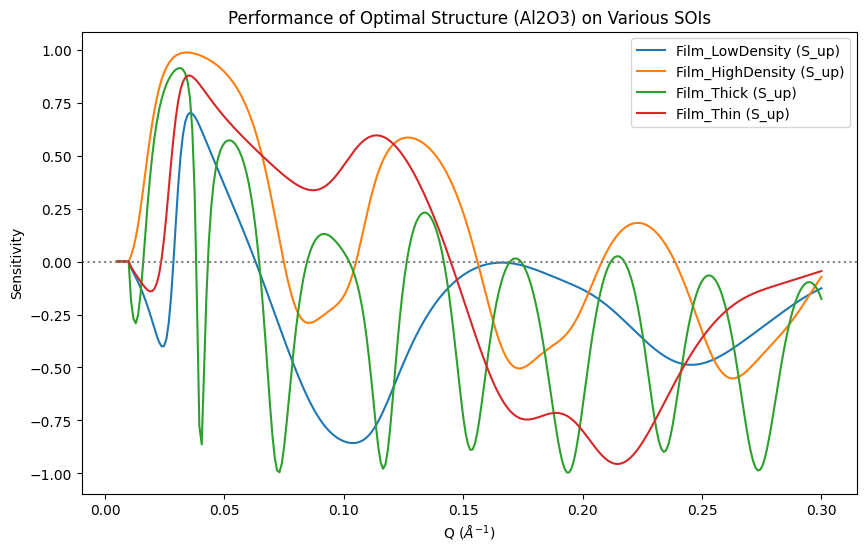

In [8]:
plt.figure(figsize=(10, 6))

# Plot Sensitivity for each SOI using the optimal parameters
for s in soi_list:
    res = problem.analyze_single_soi(
        soi=s,
        x_coti=FIXED_X_COTI,
        d_mrl=best_result["d_mrl"],
        d_cap=best_result["d_cap"],
        cap=best_result["cap"]
    )
    plt.plot(res['Q'], res['S_up'], label=f"{s.name} (S_up)")

plt.axhline(0, color='gray', linestyle=':')
plt.xlabel('Q (${\AA}^{-1}$)')
plt.ylabel('Sensitivity')
plt.title(f'Performance of Optimal Structure ({best_result["cap"]}) on Various SOIs')
plt.legend()
plt.show()